<a href="https://colab.research.google.com/github/szhang12345/MSDS-422-Assignment-7-Image-Processing-With-A-CNN/blob/main/Assignment7_Image_Processing_With_a_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### **MSDS 422 Assignment 7: Image Processing With A CNN**

**By Siying Zhang**

**Topic: Cats VS Dogs**


# Ingest

In [1]:
from __future__ import division, print_function, unicode_literals

# import base packages into the namespace for this program
import numpy as np
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import datetime
import os.path
from glob import glob

from matplotlib import pyplot as plt  # for display of images
# Loading Zip Files
import zipfile

import cv2  
#suppress tf.logging
import logging
logging.getLogger('tensorflow').disabled = True
import tensorflow.compat.v1 as tf

# Constants used in test
width = 64
height = 64
nb_epochs = 50
b_size = 20
patience_threshold = 3
lr = 1e-3

# Sets logging to file
logging.basicConfig(level=logging.DEBUG,
                    filename='tf_train.log',
                    format='%(message)s')

# Add ability to stream items to console like print
console = logging.StreamHandler()
console.setLevel(logging.INFO)
logging.getLogger('').addHandler(console)

# Clears the log if it exists
log_exists = os.path.isfile('tf_train.log')
handler = logging.handlers.RotatingFileHandler('tf_train.log', mode='w',
                                               backupCount=0)
if log_exists:
    handler.doRollover()

# Log starting parameters
logging.debug("Constants")
logging.debug("---------")
logging.debug("Dimensions {:d} by {:d}".format(width, height))
logging.debug("Epochs {:d} of batch size {:d}".format(nb_epochs, b_size))
logging.debug("Early stopping patience of {:d}".format(patience_threshold))
logging.debug("Learning rate of {}".format(lr))
logging.debug("---------")

In [2]:
!pip install -U -q PyDrive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading Data

In [6]:
# Directories containing assignment's subset of images
dir_dogs = "/content/drive/My Drive/cats_dogs_images/dogs/"
dir_cats = "/content/drive/My Drive/cats_dogs_images/cats/"

# Lists of file names of images with paths
# Checks that a file is an image given ds_store files found
img_nms_dogs = [dir_dogs+i for i in os.listdir(dir_dogs) if ".jpg" in i]
img_nms_cats = [dir_cats+i for i in os.listdir(dir_cats) if ".jpg" in i]

# Randomly shuffle images prior to partitioning
np.random.shuffle(img_nms_dogs)
np.random.shuffle(img_nms_cats)

# Partition 80% training, 10% validation, 10% testing
# Split to have as much available as possible for training given subset
img_nms_train = img_nms_dogs[0:800] + img_nms_cats[0:800]
img_nms_val = img_nms_dogs[800:900] + img_nms_cats[800:900]
img_nms_test = img_nms_dogs[900:] + img_nms_cats[900:]

# Randomly shuffle training and testing
np.random.shuffle(img_nms_train)
np.random.shuffle(img_nms_val)
np.random.shuffle(img_nms_test)

# Create labels
y_train = np.array([("dog." in i)*1 for i in img_nms_train])
y_val = np.array([("dog." in i)*1 for i in img_nms_val])
y_test = np.array([("dog." in i)*1 for i in img_nms_test])

In [7]:
def read_image(file, fx, fy, channels):
    """Read in a single image and return a resized image"""

    # Define color or gray
    if channels == 3:
        # Read image based on number of channels
        img = cv2.imread(file, 1)

        # Convert colors for plotting purposes
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif channels == 1:
        # Read image based on number of channels
        img = cv2.imread(file, 0)
    else:
        raise ValueError("Invalid 'channels'. Use 1 (grayscale) or 3 (color)")

    # Resize image based on inputs
    img_resize = cv2.resize(img, (fx, fy), interpolation=cv2.INTER_CUBIC)

    return img_resize


def load_images(image_list, fx, fy, channels):
    """Read image and output as array"""

    # Initialize array of image values
    data = np.empty((len(image_list), fx, fy, channels), dtype=np.float32)

    # Iterate through loading images to arrays
    for i, file in enumerate(image_list):
        img = read_image(file, fx, fy, channels)

        if channels == 3:
            data[i] = cv2.normalize(img, None, alpha=0, beta=1,
                                    norm_type=cv2.NORM_MINMAX,
                                    dtype=cv2.CV_32F)
        else:
            img = cv2.normalize(img, None, alpha=0, beta=1,
                                norm_type=cv2.NORM_MINMAX,
                                dtype=cv2.CV_32F)
            # Add axis to make image fx x fy x 1
            data[i] = img[:, :, np.newaxis]
    return data


def shuffle_batch(X, y, batch_size):
    """From Geron text to create batches used in training"""
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch


# Make model specification more concise
def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')


def reset_graph():
    """Reset graph and random number seeds"""
    tf.disable_v2_behavior()
    tf.compat.v1.reset_default_graph()
    tf.compat.v1.set_random_seed(42)
    np.random.seed(42)


reset_graph()


# EDA

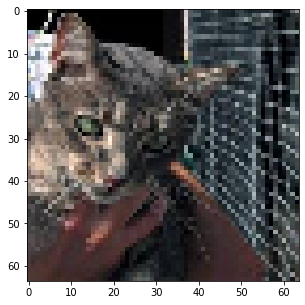

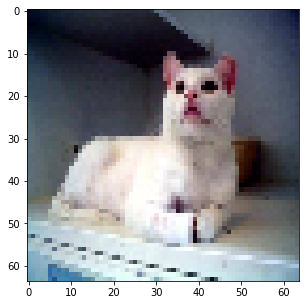

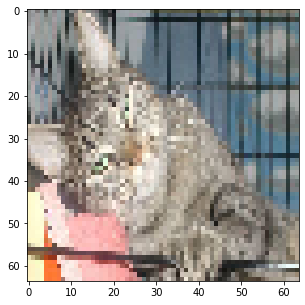

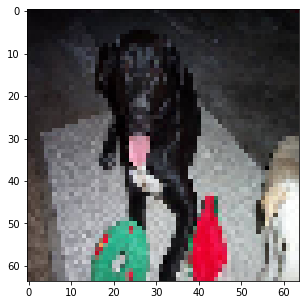

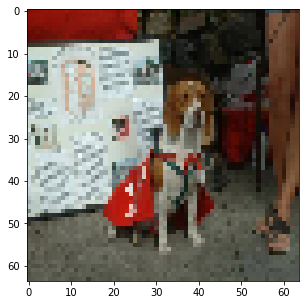

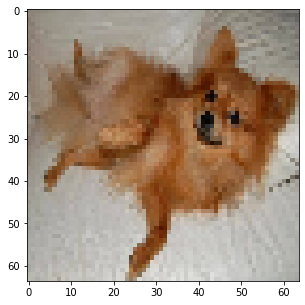

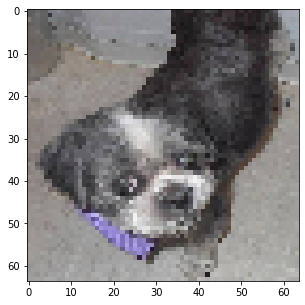

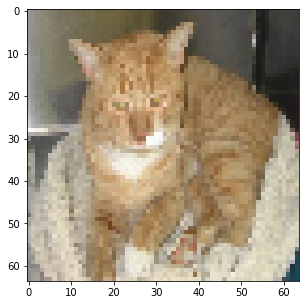

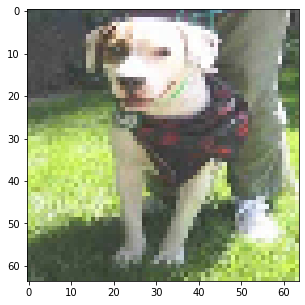

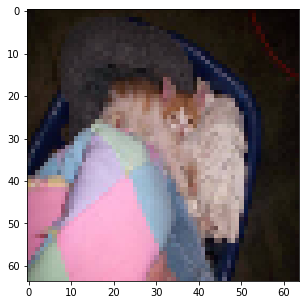

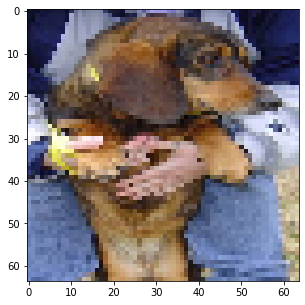

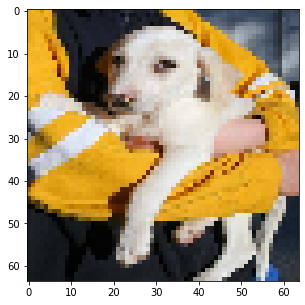

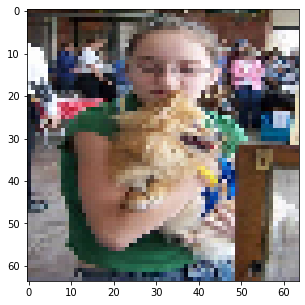

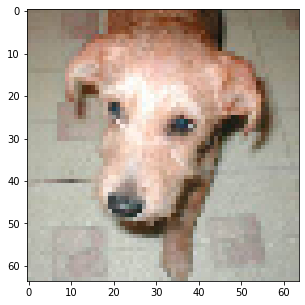

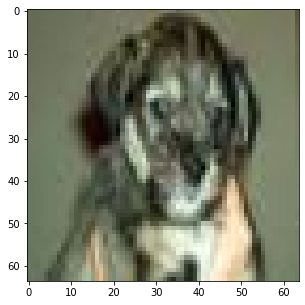

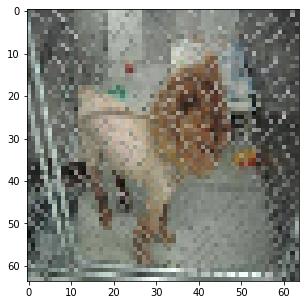

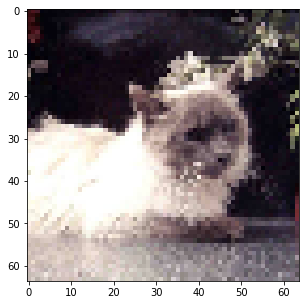

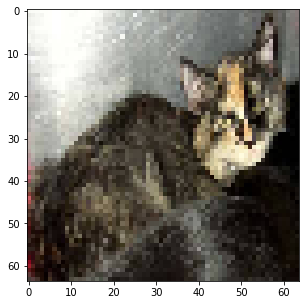

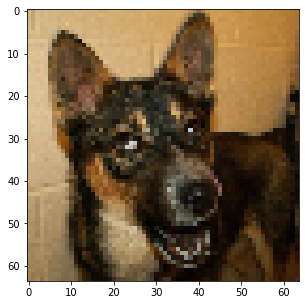

In [8]:
def show_pet_image(idx, fx, fy, channels):
    """Plot training images based on index"""
    img = read_image(img_nms_train[idx], fx, fy, channels)
    plt.figure(figsize=(10, 5))

    # Avoid greenish hue on grayscale images
    # Exception would have already been raised for invalid channel
    if channels == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=plt.cm.gray)
    plt.show()


# Plot 10 examples from the training data
for idx in range(1, 20):
    show_pet_image(idx, width, height, 3)

# Modeling

Dictionary for result tracking

In [10]:
# Initialize a dictionary to track results
metrics = {}


# Metrics for evaluation
names = ['Number of Conv Layers', 'Color', 'Time (s)',
         'Training Accuracy', 'Test Accuracy']


Model 1: 2 Hidden Layers with 100 Nodes per Layer 64x64x3 (color)

In [11]:
#Using the best performance model from Assignment 6 as the baseline model:2 layers with 100 Nodes per Layer
logging.debug("Model 1-No conv layers Baseline")
logging.debug("------------------")

reset_graph()
channel_cnt = 3

# Load images
X_train = load_images(img_nms_train, width, height, channel_cnt)
X_val = load_images(img_nms_val, width, height, channel_cnt)
X_test = load_images(img_nms_test, width, height, channel_cnt)

# Start timer
start = datetime.datetime.now()

# Set X and y placeholders

X = tf.placeholder(tf.float32, [None, width, height, channel_cnt], name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

# Flatten out image when not using convolutional layers
with tf.name_scope('reshape'):
    x_image = tf.reshape(X, [-1, width*height*channel_cnt])

# Define the fully connected layers
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(x_image, 100, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, 100, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, 2, name="outputs")
    y_proba = tf.nn.softmax(logits)

# Loss is cross entropy
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

# Use optimizer to minimize cross entropy
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(lr)
    training_op = optimizer.minimize(loss)

# Evaluate on the basis of accuracy and log loss
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_proba, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
    log_loss = tf.losses.log_loss(tf.one_hot(y, 2), y_proba)

# Train model and score on validation and test
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    # Initialize patience variables to prevent overfitting
    log_loss_prior = 99.99
    patience = 0
    
    for epoch in range(nb_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, b_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        # Generate fit statistics on training and validation data
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        log_loss_train = log_loss.eval(feed_dict={X: X_train, y: y_train})
        log_loss_val = log_loss.eval(feed_dict={X: X_val, y: y_val})
        logging.info("{}. Train Accuracy {:.4f}, Val Accuracy {:.4f}".format(str(epoch).zfill(2), acc_train, acc_val))
        logging.info("    Train Log Loss {:.4f}, Val Log Loss {:.4f}".format(log_loss_train, log_loss_val))
        
        # Stop early if validation log loss stops improving
        # Log loss is better than accuracy for measuring incremental improvement
        if log_loss_prior < log_loss_val:
            patience += 1
        if patience == patience_threshold:
            logging.info("Early Stop")
            break
        else:
            log_loss_prior = log_loss_val
    
    # Final accuracy evaluation on testing data
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})

# Record the time it takes
duration = datetime.datetime.now() - start

metrics['Model 1-No conv layers Baseline'] = [0, 'Color', duration, acc_train, acc_test]
logging.debug("------------------")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
00. Train Accuracy 0.5931, Val Accuracy 0.5350
    Train Log Loss 0.6602, Val Log Loss 0.7156
01. Train Accuracy 0.5581, Val Accuracy 0.5050
    Train Log Loss 0.7272, Val Log Loss 0.7918
02. Train Accuracy 0.6562, Val Accuracy 0.5900
    Train Log Loss 0.6223, Val Log Loss 0.6881
03. Train Accuracy 0.6212, Val Accuracy 0.5700
    Train Log Loss 0.6463, Val Log Loss 0.7100
04. Train Accuracy 0.6531, Val Accuracy 0.5750
    Train Log Loss 0.6206, Va

Specify CNN parameters

In [12]:
#  Input:
#  Conv 5x5, 32, Max Pooling 2x2
#  Conv 5x5, 64, Max Pooling 2x2
#  Optional Conv 5x5, 128, Max Pooling 2x2
#  Fully Connected 100 neurons
#  Dropout
#  Logit output layer

# Reference from Examples on the TensorFlow website
def model_spec(x, fx, fy, channels, three_conv=False):
    """Specifies a NN given image input and
    whether to use two or three convolutional layers to
    returns logits and dropout probability"""
    
    # Reshape for input into convolutional layers
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, fx, fy, channels])

    # Convolutional Layer - 32 feature maps
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([5, 5, channels, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    # 2x2 Max Pooling Layer
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1)

    # Convolutional Layer - 64 feature maps
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    # 2x2 Max Pooling
    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv2)
        
    if three_conv:
        # Convolutional Layer - 128 feature maps
        with tf.name_scope('conv3'):
            W_conv3 = weight_variable([5, 5, 64, 128])
            b_conv3 = bias_variable([128])
            h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)

        # 2x2 Max Pooling
        with tf.name_scope('pool3'):
            h_pool3 = max_pool_2x2(h_conv3)
        
    # Flatten for fully connected layers
    with tf.name_scope('flatten'):
        if three_conv:
            h_pool_flat = tf.layers.flatten(h_pool3)
        else:
            h_pool_flat = tf.layers.flatten(h_pool2)

    # Dense Layer - 100 neurons
    with tf.name_scope('fc1'):
        if three_conv:
            W_fc1 = weight_variable([int((fx/8) * (fy/8)) * 128, 100])
        else:
            W_fc1 = weight_variable([int((fx/4) * (fy/4)) * 64, 100])
            
        b_fc1 = bias_variable([100])

        h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc1) + b_fc1)
        
    # Dense Layer - 100 neurons
    with tf.name_scope('fc2'):
        W_fc2 = weight_variable([100, 100])
        b_fc2 = bias_variable([100])

        h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
                
    # Dropout Layer - with argument for drop probability
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

    # Map the dense layer features to the classes
    with tf.name_scope('fc3'):
        W_fc3 = weight_variable([100, 2])
        b_fc3 = bias_variable([2])

        logits = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
        
    return logits, keep_prob

Model 2: Color with 2 conv layers

In [13]:
logging.debug("Model 2-Color with 2 Conv Layers")
logging.debug("----------------------------------")

reset_graph()
channel_cnt = 3

# Load images
X_train = load_images(img_nms_train, width, height, channel_cnt)
X_val = load_images(img_nms_val, width, height, channel_cnt)
X_test = load_images(img_nms_test, width, height, channel_cnt)

# Start timer
start = datetime.datetime.now()

# Set X and y placeholders
X = tf.placeholder(tf.float32, [None, width, height, channel_cnt])
y = tf.placeholder(tf.int64, [None])

# Specify the model
logits, keep_prob = model_spec(X, width, height, channel_cnt, False)

# Loss is cross entropy
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(
        labels=y, logits=logits)
cross_entropy = tf.reduce_mean(cross_entropy)

# Using optimizer to minimize cross entropy
with tf.name_scope('optimizer'):
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

# Evaluate on the basis of accuracy and log loss
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)
log_loss = tf.losses.log_loss(tf.one_hot(y, 2), tf.nn.softmax(logits))
                              
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Initialize patience variables to prevent overfitting
    log_loss_prior = 99.99
    patience = 0
    
    for epoch in range(nb_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, b_size):
            train_step.run(feed_dict={X: X_batch, y: y_batch, keep_prob: 0.5})
        
        # Generate fit statistics on training and validation data
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        log_loss_train = log_loss.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        log_loss_val = log_loss.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        logging.info("{}. Train Accuracy {:.4f}, Val Accuracy {:.4f}".format(str(epoch).zfill(2), acc_train, acc_val))
        logging.info("    Train Log Loss {:.4f}, Val Log Loss {:.4f}".format(log_loss_train, log_loss_val))
        
        # Stop early if validation log loss stops improving
        # Log loss is better than accuracy for measuring incremental improvement
        if log_loss_prior < log_loss_val:
            patience += 1
        if patience == patience_threshold:
            logging.info("Early Stop")
            break
        else:
            log_loss_prior = log_loss_val
    
    # Final accuracy evaluation on testing data
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test, keep_prob: 1.0})

# Record the time it takes
duration = datetime.datetime.now() - start

metrics['Model 2-Color with 2 Conv Layers'] = [2, 'Color', duration, acc_train, acc_test]
logging.debug("-----------------------------")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
00. Train Accuracy 0.5256, Val Accuracy 0.5000
    Train Log Loss 0.6879, Val Log Loss 0.6979
01. Train Accuracy 0.6475, Val Accuracy 0.6000
    Train Log Loss 0.6634, Val Log Loss 0.6721
02. Train Accuracy 0.6919, Val Accuracy 0.6600
    Train Log Loss 0.6055, Val Log Loss 0.6327
03. Train Accuracy 0.7225, Val Accuracy 0.6500
    Train Log Loss 0.5646, Val Log Loss 0.6420
04. Train Accuracy 0.6544, Val Accuracy 0.5750
    Train Log Loss 0.58

Model 3: Color with 3 conv layers


In [14]:
logging.debug("Model 3-Color with 3 Conv Layers")
logging.debug("----------------------------------")

reset_graph()
channel_cnt = 3

# Load images
X_train = load_images(img_nms_train, width, height, channel_cnt)
X_val = load_images(img_nms_val, width, height, channel_cnt)
X_test = load_images(img_nms_test, width, height, channel_cnt)

# Start timer
start = datetime.datetime.now()

# Set X and y placeholders
X = tf.placeholder(tf.float32, [None, width, height, channel_cnt])
y = tf.placeholder(tf.int64, [None])

# Specify the model
logits, keep_prob = model_spec(X, width, height, channel_cnt, True)

# Loss is cross entropy
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(
        labels=y, logits=logits)
cross_entropy = tf.reduce_mean(cross_entropy)

# Using Adam optimizer to minimize cross entropy
with tf.name_scope('optimizer'):
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

# Evaluate on the basis of accuracy and log loss
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)
log_loss = tf.losses.log_loss(tf.one_hot(y, 2), tf.nn.softmax(logits))
                              
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Initialize patience variables to prevent overfitting
    log_loss_prior = 99.99
    patience = 0
    
    for epoch in range(nb_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, b_size):
            train_step.run(feed_dict={X: X_batch, y: y_batch, keep_prob: 0.5})
        
        # Generate fit statistics on training and validation data
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        log_loss_train = log_loss.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        log_loss_val = log_loss.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        logging.info("{:g}. Train Accuracy {:.4f}, Val Accuracy {:.4f}".format(epoch, acc_train, acc_val))
        logging.info("   Train Log Loss {:.4f}, Val Log Loss {:.4f}".format(log_loss_train, log_loss_val))
        
        # Stop early if validation log loss stops improving
        # Log loss is better than accuracy for measuring incremental improvement
        if log_loss_prior < log_loss_val:
            patience += 1
        if patience == patience_threshold:
            logging.info("Early Stop")
            break
        else:
            log_loss_prior = log_loss_val
    
    # Final accuracy evaluation on testing data
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test, keep_prob: 1.0})

# Record the time it takes
duration = datetime.datetime.now() - start

metrics['Model 3-Color with 3 conv layers'] = [3, 'Color', duration, acc_train, acc_test]
logging.debug("-----------------------------")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
0. Train Accuracy 0.5006, Val Accuracy 0.5000
   Train Log Loss 0.7087, Val Log Loss 0.7073
1. Train Accuracy 0.5163, Val Accuracy 0.5100
   Train Log Loss 0.6847, Val Log Loss 0.6867
2. Train Accuracy 0.6481, Val Accuracy 0.5750
   Train Log Loss 0.6561, Val Log Loss 0.6713
3. Train Accuracy 0.6562, Val Accuracy 0.6350
   Train Log Loss 0.6427, Val Log Loss 0.6521
4. Train Accuracy 0.7044, Val Accuracy 0.6150
   Train Log Loss 0.5627, Val Lo

Model 4: Grayscale with 2 conv layers


In [15]:
logging.debug("Model 4-Grayscale with 2 Conv Layers")
logging.debug("--------------------------------------")

reset_graph()
channel_cnt = 1

# Load images
X_train = load_images(img_nms_train, width, height, channel_cnt)
X_val = load_images(img_nms_val, width, height, channel_cnt)
X_test = load_images(img_nms_test, width, height, channel_cnt)

# Start timer
start = datetime.datetime.now()

# Set X and y placeholders
X = tf.placeholder(tf.float32, [None, width, height, channel_cnt])
y = tf.placeholder(tf.int64, [None])

# Specify the model
logits, keep_prob = model_spec(X, width, height, channel_cnt, False)

# Loss is cross entropy
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(
        labels=y, logits=logits)
cross_entropy = tf.reduce_mean(cross_entropy)

# Using optimizer to minimize cross entropy
with tf.name_scope('optimizer'):
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

# Evaluate on the basis of accuracy and log loss
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)
log_loss = tf.losses.log_loss(tf.one_hot(y, 2), tf.nn.softmax(logits))
                              
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Initialize patience variables to prevent overfitting
    log_loss_prior = 99.99
    patience = 0
    
    for epoch in range(nb_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, b_size):
            train_step.run(feed_dict={X: X_batch, y: y_batch, keep_prob: 0.5})
        
        # Generate fit statistics on training and validation data
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        log_loss_train = log_loss.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        log_loss_val = log_loss.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        logging.info("{:g}. Train Accuracy {:.4f}, Val Accuracy {:.4f}".format(epoch, acc_train, acc_val))
        logging.info("   Train Log Loss {:.4f}, Val Log Loss {:.4f}".format(log_loss_train, log_loss_val))
        
        # Stop early if validation log loss stops improving
        # Log loss is better than accuracy for measuring incremental improvement
        if log_loss_prior < log_loss_val:
            patience += 1
        if patience == patience_threshold:
            logging.info("Early Stop")
            break
        else:
            log_loss_prior = log_loss_val
    
    # Final accuracy evaluation on testing data
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test, keep_prob: 1.0})

# Record the time it takes
duration = datetime.datetime.now() - start

metrics['Model 4-Grayscale with 2 Conv Layers'] = [2, 'Grayscale', duration, acc_train, acc_test]
logging.debug("---------------------------------")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
0. Train Accuracy 0.5138, Val Accuracy 0.5450
   Train Log Loss 0.6906, Val Log Loss 0.6933
1. Train Accuracy 0.5150, Val Accuracy 0.5150
   Train Log Loss 0.6835, Val Log Loss 0.6961
2. Train Accuracy 0.6187, Val Accuracy 0.5650
   Train Log Loss 0.6670, Val Log Loss 0.6876
3. Train Accuracy 0.5444, Val Accuracy 0.5000
   Train Log Loss 0.6860, Val Log Loss 0.6942
4. Train Accuracy 0.6413, Val Accuracy 0.5450
   Train Log Loss 0.6579, Val Lo

Model 5: Grayscale with 3 conv layers

In [16]:
logging.debug("Model 5-Grayscale with 3 Conv Layers")
logging.debug("--------------------------------------")

reset_graph()
channel_cnt = 1

# Load images
X_train = load_images(img_nms_train, width, height, channel_cnt)
X_val = load_images(img_nms_val, width, height, channel_cnt)
X_test = load_images(img_nms_test, width, height, channel_cnt)

# Start timer
start = datetime.datetime.now()

# Set X and y placeholders
X = tf.placeholder(tf.float32, [None, width, height, channel_cnt])
y = tf.placeholder(tf.int64, [None])

# Specify the model
logits, keep_prob = model_spec(X, width, height, channel_cnt, True)

# Loss is cross entropy
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(
        labels=y, logits=logits)
cross_entropy = tf.reduce_mean(cross_entropy)

# Using optimizer to minimize cross entropy
with tf.name_scope('optimizer'):
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

# Evaluate on the basis of accuracy and log loss
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)
log_loss = tf.losses.log_loss(tf.one_hot(y, 2), tf.nn.softmax(logits))
                              
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Initialize patience variables to prevent overfitting
    log_loss_prior = 99.99
    patience = 0
    
    for epoch in range(nb_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, b_size):
            train_step.run(feed_dict={X: X_batch, y: y_batch, keep_prob: 0.5})
        
        # Generate fit statistics on training and validation data
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        log_loss_train = log_loss.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        log_loss_val = log_loss.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        logging.info("{:g}. Train Accuracy {:.4f}, Val Accuracy {:.4f}".format(epoch, acc_train, acc_val))
        logging.info("   Train Log Loss {:.4f}, Val Log Loss {:.4f}".format(log_loss_train, log_loss_val))
        
        # Stop early if validation log loss stops improving
        # Log loss is better than accuracy for measuring incremental improvement
        if log_loss_prior < log_loss_val:
            patience += 1
        if patience == patience_threshold:
            logging.info("Early Stop")
            break
        else:
            log_loss_prior = log_loss_val
    
    # Final accuracy evaluation on testing data
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test, keep_prob: 1.0})

# Record the time it takes
duration = datetime.datetime.now() - start

metrics['Model 5-Grayscale with 3 Conv Layers'] = [3, 'Grayscale', duration, acc_train, acc_test]
logging.debug("---------------------------------")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
0. Train Accuracy 0.5013, Val Accuracy 0.5000
   Train Log Loss 0.6949, Val Log Loss 0.6985
1. Train Accuracy 0.6181, Val Accuracy 0.5600
   Train Log Loss 0.6841, Val Log Loss 0.6878
2. Train Accuracy 0.6469, Val Accuracy 0.6300
   Train Log Loss 0.6546, Val Log Loss 0.6766
3. Train Accuracy 0.6087, Val Accuracy 0.6050
   Train Log Loss 0.6610, Val Log Loss 0.6769
4. Train Accuracy 0.5694, Val Accuracy 0.5150
   Train Log Loss 0.6716, Val Lo

In [17]:
# Convert metrics dictionary to dataframe for display
results = pd.DataFrame.from_dict(metrics, orient='index')
results.columns = names

# Sort by model number
results.reset_index(inplace=True)
results.sort_values(by=['index'], axis=0, inplace=True)
results.set_index(['index'], inplace=True)
results.index.name = None
results


,Number of Conv Layers,Color,Time (s),Training Accuracy,Test Accuracy
Model 1-No conv layers Baseline,0,Color,0 days 00:00:05.556141,0.549375,0.510
Model 2-Color with 2 Conv Layers,2,Color,0 days 00:02:59.002170,0.788125,0.610
Model 3-Color with 3 conv layers,3,Color,0 days 00:06:42.248771,0.931875,0.650
Model 4-Grayscale with 2 Conv Layers,2,Grayscale,0 days 00:02:41.836205,0.541875,0.515
Model 5-Grayscale with 3 Conv Layers,3,Grayscale,0 days 00:03:58.096391,0.620625,0.540


# Conclusion

# Background and management problem description

Continue work on the image identification problem to test neural network structures within a benchmark experiment. Using the conclusion from bench mark study to recommend the most trustworthy image classification models to a website provider who is looking for tools to automatically label images provided by end users.

# Research design and modeling methods
Utilize convolutional neural networks (CNNs) within Python TensorFlow for the competition of Dogs vs. Cats.
The steps for the analysis are the following:
1) Shuffle and resize the data and split it into training, test and validation data sets.
2) Using the best performance model from assignment 6 ‘DNN’ technique as the baseline model, 2 hidden layers with 100 nodes per layer.
3) Apply ‘CNN ‘method for filtering and processing images, 2 and 3 conv layers with color or grayscale are used.
4) Compare the model timing and accuracy.

# Results and Recommendations
Below is a summary of the models that were created in the process of this analysis and their performance comparison. Performance variables include processing time and the accuracy scores of training and test sets.

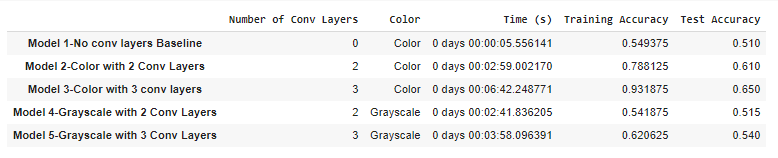


Even we used early stopping, all models with CNN preprocessing took longer time to train. The recommendation is to use model 3, processing data using 3 convolution layers with colorful images before DNN with 2 hidden layers with 100 nodes per layer. Although it takes longer to train and takes more memory to process the model, the accuracy of the test predictions is mcuh higher than the other models. In addition, compared models with the same convolution layers but different color scale, it is obvious that models fed with colorful images performed much better than those fed with grayscale images, almost 10% higher in terms of test accuracy score. This indicates that the closer fed data input is to the initial images themselves, the better outcome models would return. 

As a conclusion, implementation of the more robust model trained using higher-resolution images as the data source is recommended given the goal of achieving the highest possible accuracy in image classification with willingness of sacrificing training time. The additional processing complexity is worth the outcome.